# Project 2: Moneyball

## Part 1: Wrangling

### Problem 1

In [38]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)


query = "with total_payroll as (SELECT teamID, yearID, sum(salary) as total_payroll FROM Salaries GROUP BY teamID, yearID) SELECT Teams.teamID, Teams.yearID, total_payroll, franchID, W,((W*1.0/G)*100) as win_percentage FROM total_payroll, Teams WHERE total_payroll.yearID = Teams.yearID and total_payroll.teamID = Teams.teamID"
team_stats = pd.read_sql(query, conn)
#team_stats["yearID"].sort_values().unique()

#display one team's stats over the years
team_stats[team_stats.teamID == "ANA"]

,teamID,yearID,total_payroll,franchID,W,win_percentage
320,ANA,1997,31135472.0,ANA,84,51.851852
348,ANA,1998,41281000.0,ANA,85,52.469136
378,ANA,1999,55388166.0,ANA,70,43.209877
408,ANA,2000,51464167.0,ANA,82,50.617284
438,ANA,2001,47535167.0,ANA,75,46.296296
468,ANA,2002,61721667.0,ANA,99,61.111111
498,ANA,2003,79031667.0,ANA,77,47.530864
528,ANA,2004,100534667.0,ANA,92,56.790123


In [39]:
team_stats.head()

,teamID,yearID,total_payroll,franchID,W,win_percentage
0,ATL,1985,14807000.0,ATL,66,40.740741
1,BAL,1985,11560712.0,BAL,83,51.552795
2,BOS,1985,10897560.0,BOS,81,49.693252
3,CAL,1985,14427894.0,ANA,90,55.555556
4,CHA,1985,9846178.0,CHW,85,52.147239


We chose to do an inner join between the Salaries and Teams tables (conditioned on yearID and teamID), since this seemed most natural. Since the Salaries table does not contain any data before 1985, the inner join produces a table with team-year combinations that have only yearIDs greater than or equal to 1985, corresponding to only those combinations with actual salary data. 

## Part 2: Exploratory Data Analysis

## Payroll Distribution

To begin EDA, we will produce two plots displaying the relationship between the total payroll and time as well as winning percentage and total payroll. 

### Problem 2

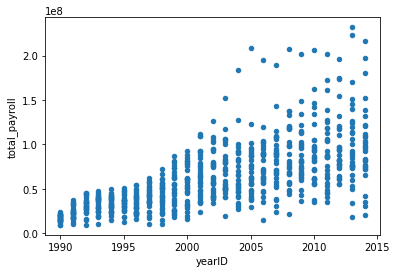

In [40]:
#Reconfigure data table to only include data from 1990 to 2014
team_stats = team_stats[team_stats.yearID >= 1990]
#produce a scatter plot of total_payroll vs. yearID
team_stats.plot.scatter("yearID", "total_payroll")

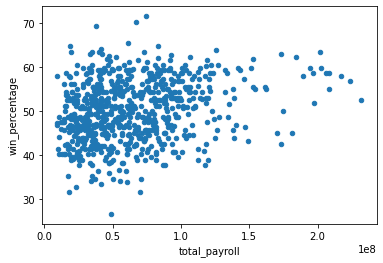

In [41]:
#Since we want to plot winning percentage as a function of total payroll, win_percentage should be on the y-axis, 
#and total_payroll on the x-axis

team_stats.plot.scatter("total_payroll", "win_percentage")

#### Question 1

From the first plot, it seems that the total_payroll increases over time. To make this clearer, we will plot the mean payroll (average over all teams) per year. It also seems that the spread of the payroll increases as time goes on, as indicated by increased incidence of extreme values. Thus we will also plot the variance of the payroll. 

### Problem 3

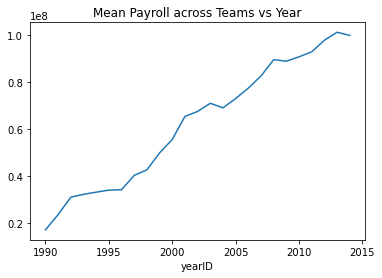

In [56]:
mean_payrolls = team_stats.groupby("yearID").mean()["total_payroll"]
mean_payrolls.plot(title="Mean Payroll across Teams vs Year")

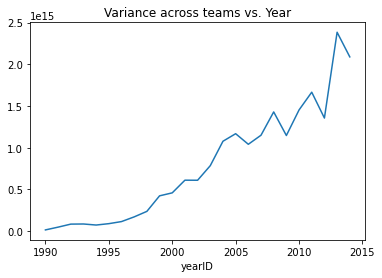

In [57]:
payrollVariance = team_stats.groupby("yearID").var()["total_payroll"]
payrollVariance.plot(title="Variance across teams vs. Year")

## Correlation Between Payroll and Winning Percentage

### Problem 4

To further investigate the relationship between payroll and winning percentage, we will create five scatter plots of mean winning percentage vs. mean payroll for five time periods (1990-1995, 1995-2000, 2000-2005, 2005-2010, 2010-2014). To do this, we will first need to discretize the data set into the aforementioned time periods. We will then calculate the mean payroll and mean winning percentage for each year. 

(1989.976, 1994.8] 0.347744863989343
(1994.8, 1999.6] 0.7394512737896316
(1999.6, 2004.4] 0.550451389521479
(2004.4, 2009.2] 0.6772792521457237
(2009.2, 2014.0] 0.47553978736494984


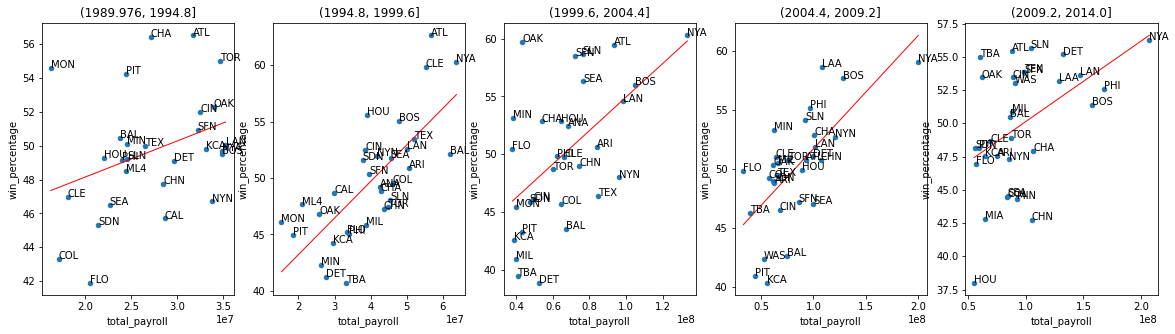

In [44]:
from scipy import stats
import numpy as np 

#cut the yearID into the 5 bins
team_stats["year_interval"] = pd.cut(team_stats.yearID, 5)

#invoke the axis object to plot multiple scatterplots
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, year_range in enumerate(team_stats["year_interval"].unique()):
    #Get only relevant data to plot (i.e. within the year range)
    range_stats = team_stats[team_stats.year_interval == year_range].groupby("teamID").mean()[["total_payroll", "win_percentage"]]


    #Create a linear regression line to add to the plot 
    slope, intercept, r_value, p_value, std_err = stats.linregress(range_stats["total_payroll"],
                                                                   range_stats["win_percentage"])
    
    #Show the correlation for purposes of analysis
    print(year_range, r_value)
    range_stats.plot.scatter(x="total_payroll", y="win_percentage", title=year_range, ax=ax[i])

    
    #make points, define a line, and then plot the regression
    pts = np.linspace(range_stats["total_payroll"].min(), range_stats["total_payroll"].max(), 500)
    line = slope * pts + intercept
    ax[i].plot(pts, line, lw=1, color='red')
    
    for k, v in range_stats.iterrows():
        ax[i].annotate(k, v)
    
    

#### Question 2

Some spans ('95-'00: .74, '05-'10: .68) have a higher correlation between payroll and win percentage than others ('90-'95: .35, '09-'14: .48); the correlation does not change in a constant direction. One can infer the efficiency of a particular team by its location on the graph -- high efficiency corresponds to low spending with a high win percentage, and thus the most efficient teams will be located in the top left of these graphs. The team with the acronym MON was a particularly efficient team from 1990-1995 and of course the A's were very efficient from 2000-2005. In the next five year span they joined the pack in terms of efficiency but were particularly efficient again from 2010-2015.

## Part 3: Data Transformation

### Problem 5

Overall, it is a bit difficult to make any strong statements about the relationship between average payroll and average winning percentage. Since individual teams have different average payrolls and standard deviations per year, we will standardize the payroll using the following formula: 

$$ standardizedPayroll_{ij} = \frac{payroll_{ij} - avgPayroll_{j}}{s_j} $$

In [45]:
for index, row in team_stats.iterrows():
    payroll_ij = row["total_payroll"]
    #we already the mean payrolls we need, as we calculated them above
    avg_payroll = mean_payrolls[row["yearID"]]
    std = team_stats.groupby("yearID").std()["total_payroll"]
    
    #apply the formula and create a new column to store the standardized value
    team_stats.at[index, "standardized_payroll"] = (payroll_ij - avg_payroll) / std[row["yearID"]]
    
team_stats.head()

,teamID,yearID,total_payroll,franchID,W,win_percentage,year_interval,standardized_payroll
130,ATL,1990,14555501.0,ATL,65,40.123457,"(1989.976, 1994.8]",-0.667275
131,BAL,1990,9680084.0,BAL,76,47.204969,"(1989.976, 1994.8]",-1.959861
132,BOS,1990,20558333.0,BOS,88,54.320988,"(1989.976, 1994.8]",0.924213
133,CAL,1990,21720000.0,ANA,80,49.382716,"(1989.976, 1994.8]",1.232198
134,CHA,1990,9491500.0,CHW,94,58.024691,"(1989.976, 1994.8]",-2.009859


### Problem 6

With the standardized payrolls, we will reproduce the five scatterplots and compare them with the ones above to see if any further insight can be gained. 

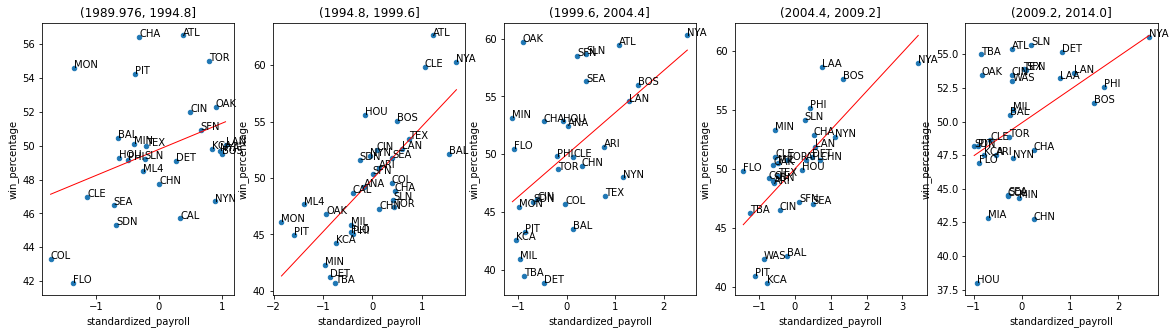

In [46]:
#cut the yearID into the 5 bins
team_stats["year_interval"] = pd.cut(team_stats.yearID, 5)

#invoke the axis object to plot multiple scatterplots
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, year_range in enumerate(team_stats["year_interval"].unique()):
    #Get only relevant data to plot (i.e. within the year range)
    range_stats = team_stats[team_stats.year_interval == year_range].groupby("teamID").mean()[["standardized_payroll", "win_percentage"]]


    #Create a linear regression line to add to the plot 
    slope, intercept, r_value, p_value, std_err = stats.linregress(range_stats["standardized_payroll"],
                                                                   range_stats["win_percentage"])
    
    range_stats.plot.scatter(x="standardized_payroll", y="win_percentage", xlabel = "Average standard payroll", title=year_range, ax=ax[i])

    
    #make points, define a line, and then plot the regression
    pts = np.linspace(range_stats["standardized_payroll"].min(), range_stats["standardized_payroll"].max(), 500)
    line = slope * pts + intercept
    ax[i].plot(pts, line, lw=1, color='red')
    
    for k, v in range_stats.iterrows():
        ax[i].annotate(k, v)

#### Question 3

This new set of graphs does not look much different from the ones produced in problem 4. However, the fact that the mean winning percentage is plotted against the average **standard** payroll allows us to make clearer statements about the trends. For example, we can see that teams who spent little more or less than the average payroll over a given time interval (like CHN and MIN from 1990-1995) typically did not win more than 50% of the time. 

### Problem 7

## Expected Wins

Since it is still a bit difficult to compare across time periods, we can produce a scatterplot of the winning percentage versus the standardized payrolls for each team. Then, we will add a regression line to get a sense of the correlation between the two variables. 

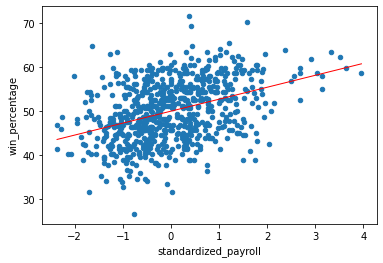

In [50]:
ax = team_stats.plot.scatter(x="standardized_payroll", y = "win_percentage", xlabel = "Standard Payroll")

slope, intercept, r_value, p_value, std_err = stats.linregress(team_stats["standardized_payroll"],
                                                                   team_stats["win_percentage"])
pts = np.linspace(team_stats["standardized_payroll"].min(), team_stats["standardized_payroll"].max(), 500)
line = slope * pts + intercept
ax.plot(pts, line, lw=1, color='red')

## Spending Efficiency

### Problem 8

Using the expected win percentage formula given in the project overview 

$$expectedWinPct_{ij} = 50 + 2.5*standardizedPayroll_{ij}$$

we can define a new metric which characterizes the spending efficiency of each team (which we will appropriately deem efficiency) as:

$$efficiency_{ij} = winPct_{ij} - expectedWinPct_{ij}$$

In [48]:
#Create the new metric as a feature of the data table
for index, row in team_stats.iterrows():
    #get expected win percentage based on regression formula
    expected_win_pct = 50 + 2.5*team_stats.at[index, "standardized_payroll"]
    
    #define efficiency and add as a column to team_stats
    team_stats.at[index, "efficiency"] = team_stats.at[index, "win_percentage"] - expected_win_pct



Now let's make a line plot of the efficiency versus the year to visualize this variable. We will choose to plot the teams with teamIDs OAK, BOS, NYA, ATL, TBA. 

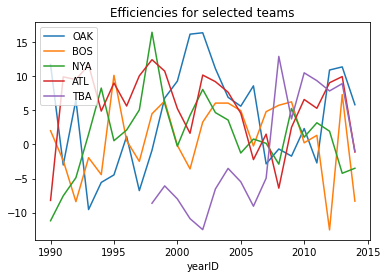

In [49]:
teams = ["OAK", "BOS", "NYA", "ATL", "TBA"]

#go through this list of teams and plot a line of the efficiency for each

fig, ax = plt.subplots()
for team in teams:
    to_plot = team_stats[team_stats.teamID == team]
    ax = to_plot.plot(ax=ax, kind='line', x='yearID', y='efficiency', label=team)

plt.title("Efficiencies for selected teams")
plt.show()


#### Question 4

Compared to the other plots, the efficiencies plot reveals the most information, since efficiency as a metric concisely captures the relationship between payroll and win percentage. While Boston and Atlanta had efficiencies that varied quite wildly over the 25 year period, Oakland, New York, and Tampa Bay each had periods of notably increased efficiency. Further, we can finally see that Oakland in particular saw a vast increase its spending efficiency during the moneyball period (2000-2005)!